**LOAD THE REQUIREMENTS**

In [3]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!ip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
!pip install tensorflow
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
"ip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Ander\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset, Subset 
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import balanced_accuracy_score
import os
import shutil
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay
from torch.optim.lr_scheduler import StepLR
import random


In [5]:
# Define dataset paths
train_labels_path = r"D:\TFM\ISIC2018_Task3_Training_GroundTruth.csv"
val_labels_path = r"D:\TFM\ISIC2018_Task3_Validation_GroundTruth.csv"
test_labels_path = r"D:\TFM\ISIC2018_Task3_Test_GroundTruth.csv"

train_pre = r"D:\TFM\ISIC2018\train"
val_pre = r"D:\TFM\ISIC2018\val"
test_pre = r"D:\TFM\ISIC2018\test"
data_dir = r"D:\TFM\data"

# Load CSV files
train_df = pd.read_csv(train_labels_path)
val_df = pd.read_csv(val_labels_path)
test_df = pd.read_csv(test_labels_path)

# Define class names
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

In [6]:
def count_images_per_class(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            count = len([file for file in os.listdir(class_folder) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

train_class_counts = count_images_per_class(r"D:\TFM\ISIC2018\train")
val_class_counts = count_images_per_class(r"D:\TFM\ISIC2018\val")
test_class_counts = count_images_per_class(r"D:\TFM\ISIC2018\test")

print("Train class counts:", train_class_counts)
print("Validation class counts:", val_class_counts)
print("Test class counts:", test_class_counts)

Train class counts: {'AKIEC': 327, 'BCC': 514, 'BKL': 1099, 'DF': 115, 'MEL': 1113, 'NV': 6705, 'VASC': 142}
Validation class counts: {'AKIEC': 8, 'BCC': 15, 'BKL': 22, 'DF': 1, 'MEL': 21, 'NV': 123, 'VASC': 3}
Test class counts: {'AKIEC': 43, 'BCC': 93, 'BKL': 217, 'DF': 44, 'MEL': 171, 'NV': 909, 'VASC': 35}


In [ ]:
def undersample_and_copy(source_folder, destination_folder, num_samples):
    # Crear la carpeta destino si no existe
    os.makedirs(destination_folder, exist_ok=True)
    
    # Listar todas las imágenes
    all_images = [img for img in os.listdir(source_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if num_samples > len(all_images):
        print(f"Warning: Requested {num_samples} images but only found {len(all_images)}. Copying all available images.")
        selected_images = all_images
    else:
        selected_images = random.sample(all_images, num_samples)
    
    # Copiar las imágenes seleccionadas
    for img in selected_images:
        src_path = os.path.join(source_folder, img)
        dst_path = os.path.join(destination_folder, img)
        shutil.copy2(src_path, dst_path)
    
    print(f"Copied {len(selected_images)} images to {destination_folder}")

# Carpetas originales
train_nv_source = r"D:\TFM\ISIC2018\train\NV"
val_nv_source = r"D:\TFM\ISIC2018\val\NV"
test_nv_source = r"D:\TFM\ISIC2018\test\NV"

# Carpetas destino (balanceadas)
train_val_nv_dest = r"D:\TFM\data\train_val\NV"
test_nv_dest = r"D:\TFM\data\test\NV"

# Primero crear carpetas temporales para separar
temp_train_nv = r"D:\TFM\temp\train\NV"
temp_val_nv = r"D:\TFM\temp\val\NV"

# 1. Undersample
undersample_and_copy(train_nv_source, temp_train_nv, 1000)  # Train con 1000 NV
undersample_and_copy(val_nv_source, temp_val_nv, 22)        # Val con 22 NV
undersample_and_copy(test_nv_source, test_nv_dest, 250)     # Test con 250 NV

# 2. Ahora juntar train y val en carpeta final
# Crear carpeta final si no existe
os.makedirs(train_val_nv_dest, exist_ok=True)

# Copiar de train undersampled
for img in os.listdir(temp_train_nv):
    src = os.path.join(temp_train_nv, img)
    dst = os.path.join(train_val_nv_dest, img)
    shutil.copy2(src, dst)

# Copiar de val undersampled
for img in os.listdir(temp_val_nv):
    src = os.path.join(temp_val_nv, img)
    dst = os.path.join(train_val_nv_dest, img)
    shutil.copy2(src, dst)

print("Finished creating balanced NV folders for train_val and test!")


Copied 1000 images to D:\TFM\temp\train\NV
Copied 22 images to D:\TFM\temp\val\NV
Copied 250 images to D:\TFM\data\test\NV
Finished creating balanced NV folders for train_val and test!


In [32]:
# Definir las clases
classes = ['MEL', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

# Paths originales
train_source_base = r"D:\TFM\ISIC2018\train"
val_source_base = r"D:\TFM\ISIC2018\val"
test_source_base = r"D:\TFM\ISIC2018\test"

# Paths destino
train_val_dest_base = r"D:\TFM\data\train_val"
test_dest_base = r"D:\TFM\data\test"

# Función para copiar imágenes
def copy_all_images(source_folder, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    for img in os.listdir(source_folder):
        src = os.path.join(source_folder, img)
        dst = os.path.join(destination_folder, img)
        if os.path.isfile(src):
            shutil.copy2(src, dst)

# Para cada clase
for cls in classes:
    print(f"Copying class: {cls}")

    # Crear carpetas de destino
    train_val_cls_dest = os.path.join(train_val_dest_base, cls)
    test_cls_dest = os.path.join(test_dest_base, cls)
    
    os.makedirs(train_val_cls_dest, exist_ok=True)
    os.makedirs(test_cls_dest, exist_ok=True)

    # Copiar imágenes de train
    train_cls_source = os.path.join(train_source_base, cls)
    if os.path.exists(train_cls_source):
        copy_all_images(train_cls_source, train_val_cls_dest)
    
    # Copiar imágenes de val
    val_cls_source = os.path.join(val_source_base, cls)
    if os.path.exists(val_cls_source):
        copy_all_images(val_cls_source, train_val_cls_dest)

    # Copiar imágenes de test
    test_cls_source = os.path.join(test_source_base, cls)
    if os.path.exists(test_cls_source):
        copy_all_images(test_cls_source, test_cls_dest)

print("Finished copying all other classes!")

Copying class: MEL
Copying class: BCC
Copying class: AKIEC
Copying class: BKL
Copying class: DF
Copying class: VASC
Finished copying all other classes!


In [34]:
# Función para contar imágenes por clase
def count_images_per_class(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            count = len([file for file in os.listdir(class_folder) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
            class_counts[class_name] = count
    return class_counts

# Contar en las nuevas carpetas
train_val_counts = count_images_per_class(r"D:\TFM\data\train_val")
test_counts = count_images_per_class(r"D:\TFM\data\test")

# Mostrar resultados
print("Train+Val class counts:", train_val_counts)
print("Test class counts:", test_counts)


Train+Val class counts: {'AKIEC': 335, 'BCC': 529, 'BKL': 1121, 'DF': 116, 'MEL': 1134, 'NV': 1022, 'VASC': 145}
Test class counts: {'AKIEC': 43, 'BCC': 93, 'BKL': 217, 'DF': 44, 'MEL': 171, 'NV': 250, 'VASC': 35}


**PREPROCESS**

In [9]:
# Data Transforms (resize all images to 64x64, then convert to tensor)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor(),  # Convert images to tensors
    # Optional: Normalize if needed
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Early Stopping Class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.best_model_wts = None

    def __call__(self, model, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f'Validation loss decreased ({self.best_loss:.4f} -> {val_loss:.4f}). Saving model...')
            self.best_model_wts = model.state_dict()
            torch.save(self.best_model_wts, self.path)
        else:
            self.counter += 1
            if self.verbose:
                print(f'Validation loss did not improve. Counter: {self.counter}/{self.patience}')

        if self.counter >= self.patience:
            print('Early stopping triggered')
            return True
        return False
    
# Define a simpler CNN model with Batch Normalization, Dropout, and L2 Regularization (weight decay)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):  # num_classes is 7 for ISIC 2018
        super(SimpleCNN, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization after conv1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # MaxPooling layer
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization after conv2
        
        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch Normalization after conv3
        
        # Fully Connected Layer (after flattening the output of convolutional layers)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 64 channels, 8x8 feature maps after pooling
        self.dropout = nn.Dropout(0.4)  # Dropout layer with 40% probability
        self.fc2 = nn.Linear(512, num_classes)  # Final output layer with the number of classes

    def forward(self, x):
        # Apply first convolutional layer with ReLU and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        
        # Apply second convolutional layer with ReLU and batch normalization
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Apply third convolutional layer with ReLU and batch normalization
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output to feed into the fully connected layer
        x = x.view(-1, 64 * 8 * 8)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Final output layer
        
        return x

Fold 1/5
Validation loss decreased (1.2088 -> 1.2088). Saving model...
Validation loss decreased (1.1422 -> 1.1422). Saving model...
Validation loss did not improve. Counter: 1/15
Validation loss decreased (1.0874 -> 1.0874). Saving model...
Validation loss did not improve. Counter: 1/15
Validation loss did not improve. Counter: 2/15
Validation loss decreased (1.0745 -> 1.0745). Saving model...
Validation loss decreased (1.0621 -> 1.0621). Saving model...
Validation loss did not improve. Counter: 1/15
Validation loss did not improve. Counter: 2/15
Validation loss did not improve. Counter: 3/15
Validation loss decreased (1.0452 -> 1.0452). Saving model...
Validation loss decreased (1.0214 -> 1.0214). Saving model...
Validation loss did not improve. Counter: 1/15
Validation loss did not improve. Counter: 2/15
Validation loss did not improve. Counter: 3/15
Validation loss did not improve. Counter: 4/15
Validation loss did not improve. Counter: 5/15
Validation loss did not improve. Counter

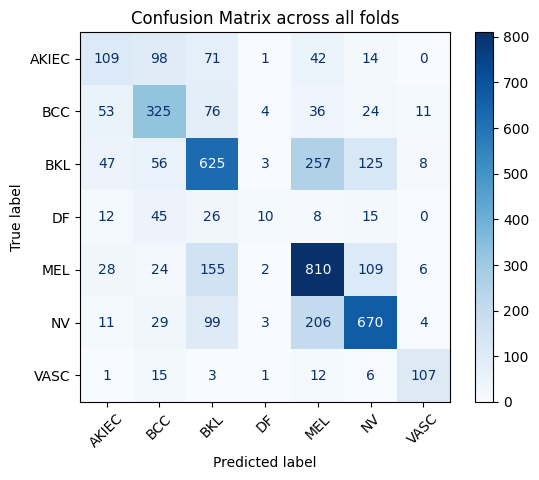

In [37]:
# --- Load dataset ---
dataset = datasets.ImageFolder(root=r"D:\TFM\data\train_val", transform=transform)

# Get labels for StratifiedKFold
targets = np.array(dataset.targets)

# --- Cross-validation setup ---
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store predictions and true labels for confusion matrix
all_preds = []
all_labels = []

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Start 5-Fold Cross-Validation ---
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Create data loaders
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
    
    # Initialize model
    model = SimpleCNN(num_classes=7).to(device)
    
    # Optimizer with L2 regularization (weight decay)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Early stopping
    early_stopper = EarlyStopping(patience=15, verbose=True, path=f'best_model_fold{fold}.pth')
    
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        if early_stopper(model, avg_val_loss):
            break
    
    # Load best model weights for this fold
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))
    
    # Evaluate on validation set
    model.eval()
    fold_preds = []
    fold_labels = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())
    
    # Store for confusion matrix
    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)
    
    # Metrics for this fold
    acc = accuracy_score(fold_labels, fold_preds)
    prec = precision_score(fold_labels, fold_preds, average='macro', zero_division=0)
    rec = recall_score(fold_labels, fold_preds, average='macro', zero_division=0)
    f1 = f1_score(fold_labels, fold_preds, average='macro', zero_division=0)
    
    print(f"Fold {fold+1} Metrics:")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1 Score: {f1:.4f}")
    print('-' * 30)

# --- Confusion Matrix for all folds ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix across all folds")
plt.show()

In [6]:
# Dataset and DataLoader (preprocessed images with no additional transformations)
train_dataset = ImageFolder(train_pre, transform=transform)
val_dataset = ImageFolder(val_pre, transform=transform)
test_dataset = ImageFolder(test_pre, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




======== Fold 1 ========
Validation loss decreased (1.3311 -> 1.3311). Saving model...
Validation loss decreased (1.2240 -> 1.2240). Saving model...
Validation loss decreased (1.1314 -> 1.1314). Saving model...
Validation loss did not improve. Counter: 1/20
Validation loss did not improve. Counter: 2/20
Validation loss decreased (1.1174 -> 1.1174). Saving model...
Validation loss decreased (1.0951 -> 1.0951). Saving model...
Validation loss did not improve. Counter: 1/20
Validation loss did not improve. Counter: 2/20
Validation loss decreased (1.0940 -> 1.0940). Saving model...
Validation loss decreased (1.0005 -> 1.0005). Saving model...
Validation loss did not improve. Counter: 1/20
Validation loss did not improve. Counter: 2/20
Validation loss did not improve. Counter: 3/20
Validation loss did not improve. Counter: 4/20
Validation loss did not improve. Counter: 5/20
Validation loss did not improve. Counter: 6/20
Validation loss did not improve. Counter: 7/20
Validation loss did not

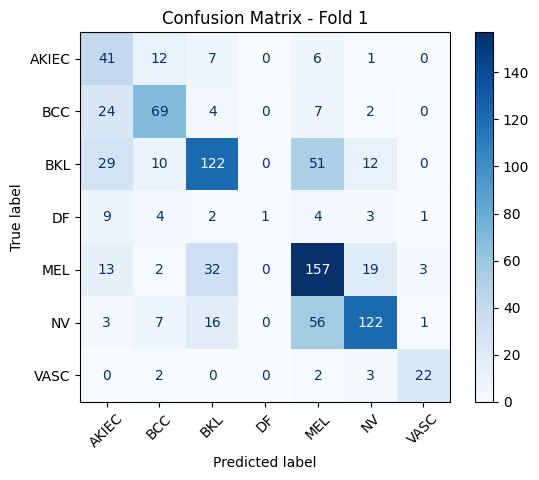

Classification Report - Fold 1
              precision    recall  f1-score   support

       AKIEC     0.3445    0.6119    0.4409        67
         BCC     0.6509    0.6509    0.6509       106
         BKL     0.6667    0.5446    0.5995       224
          DF     1.0000    0.0417    0.0800        24
         MEL     0.5548    0.6947    0.6169       226
          NV     0.7531    0.5951    0.6649       205
        VASC     0.8148    0.7586    0.7857        29

    accuracy                         0.6061       881
   macro avg     0.6835    0.5568    0.5484       881
weighted avg     0.6456    0.6061    0.6053       881

Per-class accuracy (Fold 1):
AKIEC: 0.6119
BCC: 0.6509
BKL: 0.5446
DF: 0.0417
MEL: 0.6947
NV: 0.5951
VASC: 0.7586

Fold 1 Scores:
Accuracy: 0.6061 | Precision: 0.6835 | Recall: 0.5568 | F1 Score: 0.5484

======== Fold 2 ========
Validation loss decreased (1.4282 -> 1.4282). Saving model...
Validation loss decreased (1.2838 -> 1.2838). Saving model...
Validation loss did

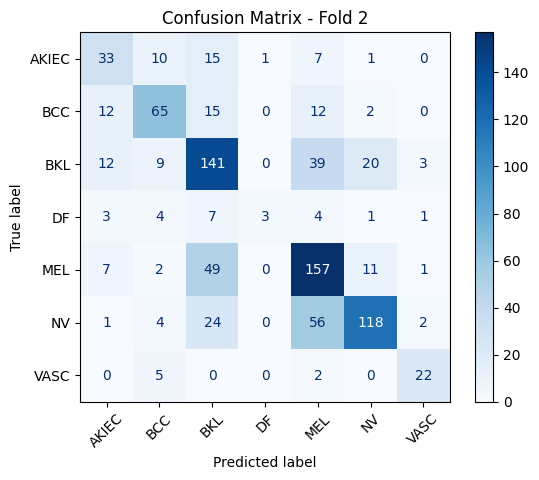

Classification Report - Fold 2
              precision    recall  f1-score   support

       AKIEC     0.4853    0.4925    0.4889        67
         BCC     0.6566    0.6132    0.6341       106
         BKL     0.5618    0.6295    0.5937       224
          DF     0.7500    0.1304    0.2222        23
         MEL     0.5668    0.6916    0.6230       227
          NV     0.7712    0.5756    0.6592       205
        VASC     0.7586    0.7586    0.7586        29

    accuracy                         0.6118       881
   macro avg     0.6500    0.5559    0.5685       881
weighted avg     0.6288    0.6118    0.6091       881

Per-class accuracy (Fold 2):
AKIEC: 0.4925
BCC: 0.6132
BKL: 0.6295
DF: 0.1304
MEL: 0.6916
NV: 0.5756
VASC: 0.7586

Fold 2 Scores:
Accuracy: 0.6118 | Precision: 0.6500 | Recall: 0.5559 | F1 Score: 0.5685

======== Fold 3 ========
Validation loss decreased (1.3728 -> 1.3728). Saving model...
Validation loss decreased (1.1333 -> 1.1333). Saving model...
Validation loss did

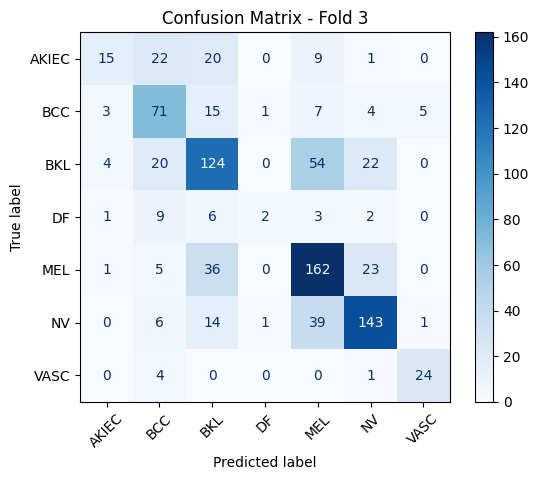

Classification Report - Fold 3
              precision    recall  f1-score   support

       AKIEC     0.6250    0.2239    0.3297        67
         BCC     0.5182    0.6698    0.5844       106
         BKL     0.5767    0.5536    0.5649       224
          DF     0.5000    0.0870    0.1481        23
         MEL     0.5912    0.7137    0.6467       227
          NV     0.7296    0.7010    0.7150       204
        VASC     0.8000    0.8276    0.8136        29

    accuracy                         0.6148       880
   macro avg     0.6201    0.5395    0.5432       880
weighted avg     0.6179    0.6148    0.6025       880

Per-class accuracy (Fold 3):
AKIEC: 0.2239
BCC: 0.6698
BKL: 0.5536
DF: 0.0870
MEL: 0.7137
NV: 0.7010
VASC: 0.8276

Fold 3 Scores:
Accuracy: 0.6148 | Precision: 0.6201 | Recall: 0.5395 | F1 Score: 0.5432

======== Fold 4 ========
Validation loss decreased (1.3357 -> 1.3357). Saving model...
Validation loss decreased (1.1991 -> 1.1991). Saving model...
Validation loss dec

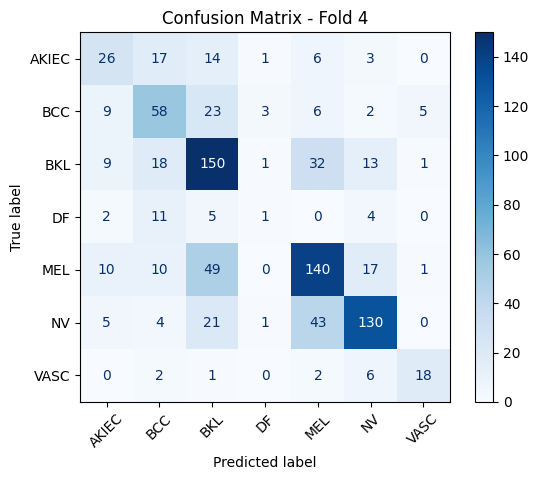

Classification Report - Fold 4
              precision    recall  f1-score   support

       AKIEC     0.4262    0.3881    0.4062        67
         BCC     0.4833    0.5472    0.5133       106
         BKL     0.5703    0.6696    0.6160       224
          DF     0.1429    0.0435    0.0667        23
         MEL     0.6114    0.6167    0.6140       227
          NV     0.7429    0.6373    0.6860       204
        VASC     0.7200    0.6207    0.6667        29

    accuracy                         0.5943       880
   macro avg     0.5281    0.5033    0.5098       880
weighted avg     0.5932    0.5943    0.5907       880

Per-class accuracy (Fold 4):
AKIEC: 0.3881
BCC: 0.5472
BKL: 0.6696
DF: 0.0435
MEL: 0.6167
NV: 0.6373
VASC: 0.6207

Fold 4 Scores:
Accuracy: 0.5943 | Precision: 0.5281 | Recall: 0.5033 | F1 Score: 0.5098

======== Fold 5 ========
Validation loss decreased (1.3939 -> 1.3939). Saving model...
Validation loss decreased (1.2668 -> 1.2668). Saving model...
Validation loss did

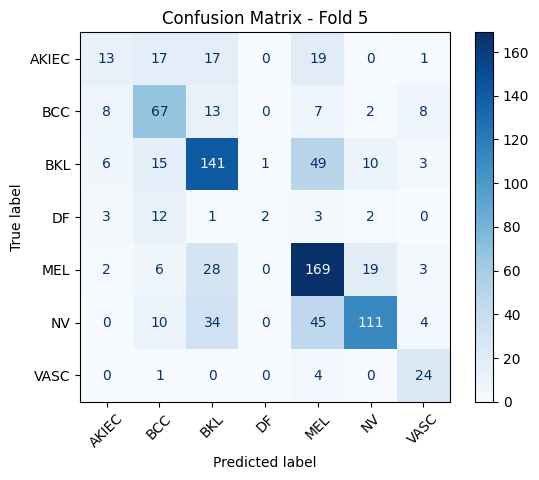

Classification Report - Fold 5
              precision    recall  f1-score   support

       AKIEC     0.4062    0.1940    0.2626        67
         BCC     0.5234    0.6381    0.5751       105
         BKL     0.6026    0.6267    0.6144       225
          DF     0.6667    0.0870    0.1538        23
         MEL     0.5709    0.7445    0.6463       227
          NV     0.7708    0.5441    0.6379       204
        VASC     0.5581    0.8276    0.6667        29

    accuracy                         0.5989       880
   macro avg     0.5855    0.5231    0.5081       880
weighted avg     0.6092    0.5989    0.5863       880

Per-class accuracy (Fold 5):
AKIEC: 0.1940
BCC: 0.6381
BKL: 0.6267
DF: 0.0870
MEL: 0.7445
NV: 0.5441
VASC: 0.8276

Fold 5 Scores:
Accuracy: 0.5989 | Precision: 0.5855 | Recall: 0.5231 | F1 Score: 0.5081

======== Final Combined Results (All Folds) ========


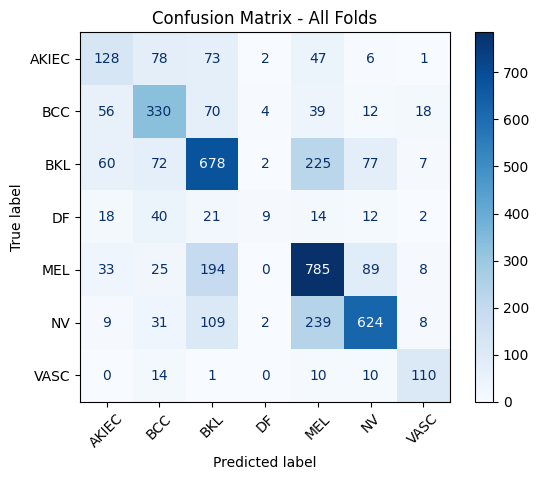

Final Classification Report (All folds)
              precision    recall  f1-score   support

       AKIEC     0.4211    0.3821    0.4006       335
         BCC     0.5593    0.6238    0.5898       529
         BKL     0.5916    0.6048    0.5981      1121
          DF     0.4737    0.0776    0.1333       116
         MEL     0.5776    0.6922    0.6298      1134
          NV     0.7518    0.6106    0.6739      1022
        VASC     0.7143    0.7586    0.7358       145

    accuracy                         0.6052      4402
   macro avg     0.5842    0.5357    0.5373      4402
weighted avg     0.6093    0.6052    0.6001      4402



In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    classification_report
)


# --- Load Dataset ---
data_path = r"D:\TFM\data\train_val"
dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = np.array(dataset.targets)
class_names = dataset.classes

# --- K-Fold setup ---
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Metrics across all folds ---
all_preds = []
all_labels = []

# --- Cross-validation loop ---
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f'\n======== Fold {fold + 1} ========')

    # Subsets
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    # Model, loss, optimizer
    model = SimpleCNN(num_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    early_stopping = EarlyStopping(patience=20, verbose=True, path=f'best_model_fold{fold}.pth')

    # --- Training loop ---
    for epoch in range(50):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        if early_stopping(model, avg_val_loss):
            break

    # Load best weights
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth'))

    # --- Final Evaluation for this fold ---
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    # --- Confusion Matrix for this fold ---
    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

    # --- Classification Report ---
    print(f"Classification Report - Fold {fold+1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4, zero_division=0))

    # --- Per-Class Accuracy ---
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print(f"Per-class accuracy (Fold {fold+1}):")
    for idx, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_acc[idx]:.4f}")

    # --- Global Metrics ---
    acc = accuracy_score(fold_labels, fold_preds)
    prec = precision_score(fold_labels, fold_preds, average='macro', zero_division=0)
    rec = recall_score(fold_labels, fold_preds, average='macro', zero_division=0)
    f1 = f1_score(fold_labels, fold_preds, average='macro', zero_division=0)
    print(f"\nFold {fold+1} Scores:")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")

# --- Final Combined Confusion Matrix ---
print("\n======== Final Combined Results (All Folds) ========")
final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - All Folds")
plt.show()

# Final classification report
print("Final Classification Report (All folds)")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0))


In [7]:
import os
import shutil

# Rutas originales
train_original = r"D:\TFM\ISIC2018\train"
val_original = r"D:\TFM\ISIC2018\val"

# Ruta combinada (sin balanceo)
combined_path = r"D:\TFM\data\train_val_full"

# Crear carpetas de clases combinadas
classes = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
for cls in classes:
    dst = os.path.join(combined_path, cls)
    os.makedirs(dst, exist_ok=True)

    for src_base in [train_original, val_original]:
        src_folder = os.path.join(src_base, cls)
        if os.path.exists(src_folder):
            for img in os.listdir(src_folder):
                src_path = os.path.join(src_folder, img)
                dst_path = os.path.join(dst, img)
                shutil.copy2(src_path, dst_path)

print("Combinación de carpetas de train y val SIN undersampling completada.")


Combinación de carpetas de train y val SIN undersampling completada.



======== Fold 1 ========
Validation loss decreased (0.8831 -> 0.8831). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.7792 -> 0.7792). Saving model...
Validation loss decreased (0.7086 -> 0.7086). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6805 -> 0.6805). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6476 -> 0.6476). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6429 -> 0.6429). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Validation loss did not improve. Counter: 3/10
Validation loss did not improve. Counter: 4/10
Validation loss did not improve. Counter: 5/10
Validation loss did not improve. Counter: 6/10
Validation loss did not improve. Counter: 7/10
Validation loss did not improve. Counter: 8/10
Validation loss did not improve. Count

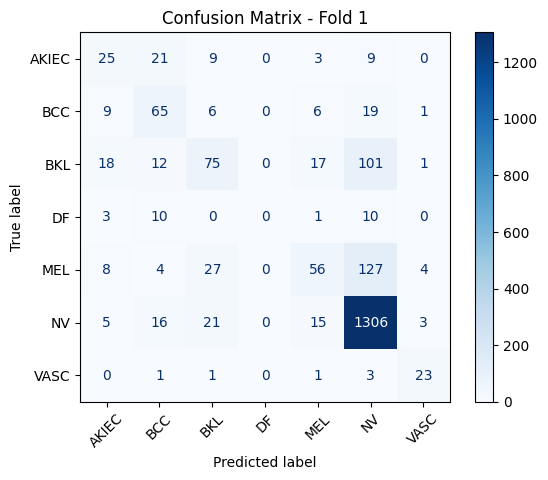

Classification Report - Fold 1
              precision    recall  f1-score   support

       AKIEC     0.3676    0.3731    0.3704        67
         BCC     0.5039    0.6132    0.5532       106
         BKL     0.5396    0.3348    0.4132       224
          DF     0.0000    0.0000    0.0000        24
         MEL     0.5657    0.2478    0.3446       226
          NV     0.8292    0.9561    0.8881      1366
        VASC     0.7188    0.7931    0.7541        29

    accuracy                         0.7591      2042
   macro avg     0.5035    0.4740    0.4748      2042
weighted avg     0.7249    0.7591    0.7292      2042

Fold 1 - Acc: 0.7591 | Prec: 0.5035 | Rec: 0.4740 | F1: 0.4748

======== Fold 2 ========
Validation loss decreased (0.8217 -> 0.8217). Saving model...
Validation loss decreased (0.8179 -> 0.8179). Saving model...
Validation loss decreased (0.7170 -> 0.7170). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss did not improve. Counter: 2/10
Val

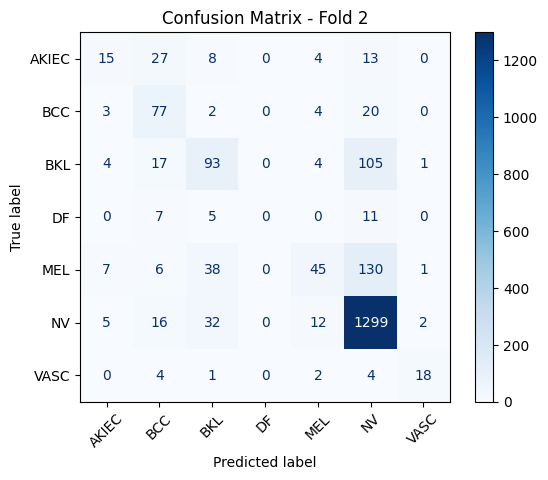

Classification Report - Fold 2
              precision    recall  f1-score   support

       AKIEC     0.4412    0.2239    0.2970        67
         BCC     0.5000    0.7264    0.5923       106
         BKL     0.5196    0.4152    0.4615       224
          DF     0.0000    0.0000    0.0000        23
         MEL     0.6338    0.1982    0.3020       227
          NV     0.8211    0.9510    0.8813      1366
        VASC     0.8182    0.6207    0.7059        29

    accuracy                         0.7576      2042
   macro avg     0.5334    0.4479    0.4629      2042
weighted avg     0.7288    0.7576    0.7243      2042

Fold 2 - Acc: 0.7576 | Prec: 0.5334 | Rec: 0.4479 | F1: 0.4629

======== Fold 3 ========
Validation loss decreased (0.9606 -> 0.9606). Saving model...
Validation loss decreased (0.7892 -> 0.7892). Saving model...
Validation loss decreased (0.7660 -> 0.7660). Saving model...
Validation loss decreased (0.7621 -> 0.7621). Saving model...
Validation loss decreased (0.6719 -

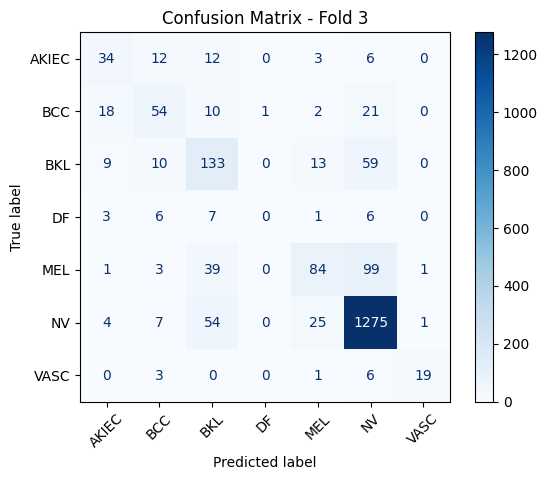

Classification Report - Fold 3
              precision    recall  f1-score   support

       AKIEC     0.4928    0.5075    0.5000        67
         BCC     0.5684    0.5094    0.5373       106
         BKL     0.5216    0.5938    0.5553       224
          DF     0.0000    0.0000    0.0000        23
         MEL     0.6512    0.3700    0.4719       227
          NV     0.8662    0.9334    0.8985      1366
        VASC     0.9048    0.6552    0.7600        29

    accuracy                         0.7831      2042
   macro avg     0.5721    0.5099    0.5319      2042
weighted avg     0.7675    0.7831    0.7695      2042

Fold 3 - Acc: 0.7831 | Prec: 0.5721 | Rec: 0.5099 | F1: 0.5319

======== Fold 4 ========
Validation loss decreased (0.8527 -> 0.8527). Saving model...
Validation loss decreased (0.7718 -> 0.7718). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.7606 -> 0.7606). Saving model...
Validation loss did not improve. Counter: 1/10
Val

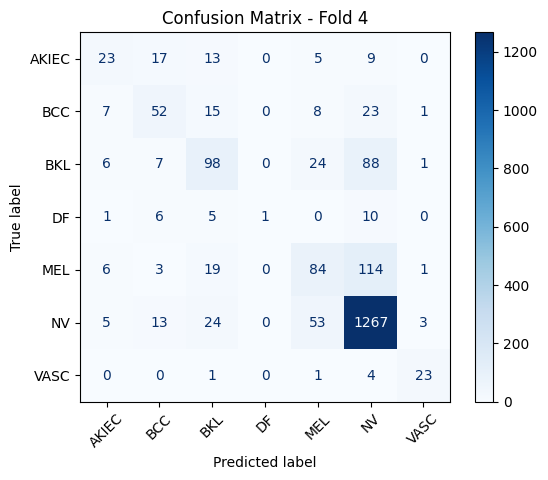

Classification Report - Fold 4
              precision    recall  f1-score   support

       AKIEC     0.4792    0.3433    0.4000        67
         BCC     0.5306    0.4906    0.5098       106
         BKL     0.5600    0.4375    0.4912       224
          DF     1.0000    0.0435    0.0833        23
         MEL     0.4800    0.3700    0.4179       227
          NV     0.8363    0.9282    0.8799      1365
        VASC     0.7931    0.7931    0.7931        29

    accuracy                         0.7585      2041
   macro avg     0.6685    0.4866    0.5107      2041
weighted avg     0.7400    0.7585    0.7407      2041

Fold 4 - Acc: 0.7585 | Prec: 0.6685 | Rec: 0.4866 | F1: 0.5107

======== Fold 5 ========
Validation loss decreased (0.7962 -> 0.7962). Saving model...
Validation loss decreased (0.7531 -> 0.7531). Saving model...
Validation loss decreased (0.7249 -> 0.7249). Saving model...
Validation loss did not improve. Counter: 1/10
Validation loss decreased (0.6814 -> 0.6814). Savi

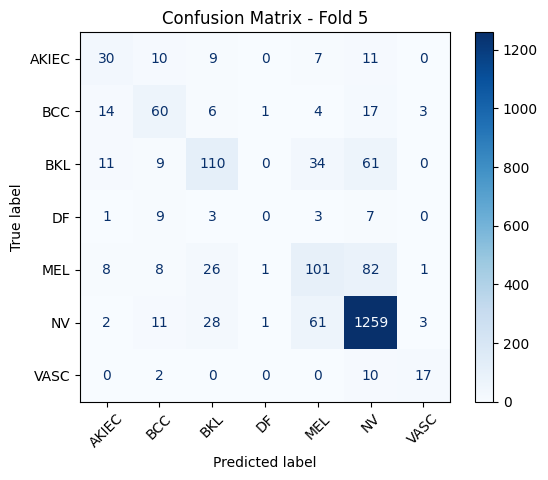

Classification Report - Fold 5
              precision    recall  f1-score   support

       AKIEC     0.4545    0.4478    0.4511        67
         BCC     0.5505    0.5714    0.5607       105
         BKL     0.6044    0.4889    0.5405       225
          DF     0.0000    0.0000    0.0000        23
         MEL     0.4810    0.4449    0.4622       227
          NV     0.8701    0.9223    0.8954      1365
        VASC     0.7083    0.5862    0.6415        29

    accuracy                         0.7727      2041
   macro avg     0.5241    0.4945    0.5074      2041
weighted avg     0.7553    0.7727    0.7626      2041

Fold 5 - Acc: 0.7727 | Prec: 0.5241 | Rec: 0.4945 | F1: 0.5074

======== Final Results ========


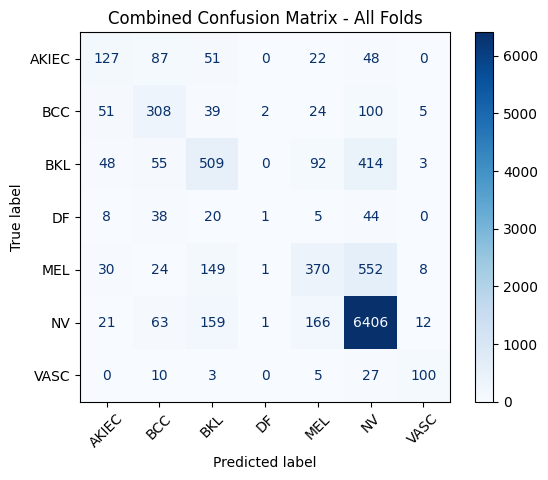

Final Classification Report:
              precision    recall  f1-score   support

       AKIEC     0.4456    0.3791    0.4097       335
         BCC     0.5265    0.5822    0.5530       529
         BKL     0.5473    0.4541    0.4963      1121
          DF     0.2000    0.0086    0.0165       116
         MEL     0.5409    0.3263    0.4070      1134
          NV     0.8439    0.9382    0.8885      6828
        VASC     0.7812    0.6897    0.7326       145

    accuracy                         0.7662     10208
   macro avg     0.5551    0.4826    0.5005     10208
weighted avg     0.7399    0.7662    0.7468     10208



In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, ConfusionMatrixDisplay, classification_report
)
import numpy as np
import matplotlib.pyplot as plt


# --- Dataset ---
data_path = r"D:\TFM\data\train_val_full"
dataset = datasets.ImageFolder(root=data_path, transform=transform)
targets = np.array(dataset.targets)
class_names = dataset.classes

# --- K-Fold ---
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Placeholder para métricas combinadas
all_preds = []
all_labels = []


# --- K-Fold Entrenamiento ---
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n======== Fold {fold + 1} ========")

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = SimpleCNN(num_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    early_stopping = EarlyStopping(patience=10, verbose=True, path=f'model_fold{fold}.pth')

    for epoch in range(50):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0.0
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        if early_stopping(model, avg_val_loss):
            break

    model.load_state_dict(torch.load(f'model_fold{fold}.pth'))
    model.eval()
    fold_preds, fold_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            fold_preds.extend(preds.cpu().numpy())
            fold_labels.extend(labels.cpu().numpy())

    all_preds.extend(fold_preds)
    all_labels.extend(fold_labels)

    cm = confusion_matrix(fold_labels, fold_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

    print(f"Classification Report - Fold {fold+1}")
    print(classification_report(fold_labels, fold_preds, target_names=class_names, digits=4, zero_division=0))

    acc = accuracy_score(fold_labels, fold_preds)
    prec = precision_score(fold_labels, fold_preds, average='macro', zero_division=0)
    rec = recall_score(fold_labels, fold_preds, average='macro', zero_division=0)
    f1 = f1_score(fold_labels, fold_preds, average='macro', zero_division=0)
    print(f"Fold {fold+1} - Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f}")

# --- Resultados finales ---
print("\n======== Final Results ========")
final_cm = confusion_matrix(all_labels, all_preds)
final_disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=class_names)
final_disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Combined Confusion Matrix - All Folds")
plt.show()

print("Final Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4, zero_division=0))


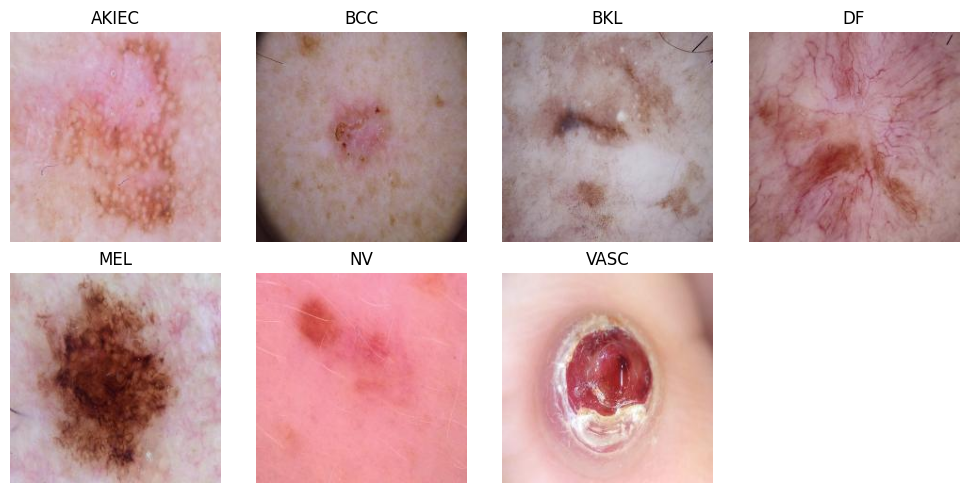

In [18]:
# Assuming test_pre is the path to your test dataset folder
test_dataset1 = datasets.ImageFolder(test_pre)  # No transformations

# Get the class names
class_names = test_dataset1.classes

# Initialize the plot grid (2 rows and 4 columns)
fig, axes = plt.subplots(2, 4, figsize=(10, 5))  # 2 rows, 4 columns with a smaller figure size

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over each class and pick one image
for i, class_name in enumerate(class_names):
    # Get one image from the test dataset for this class
    class_idx = test_dataset1.class_to_idx[class_name]
    class_indices = [idx for idx, label in enumerate(test_dataset1.targets) if label == class_idx]
    
    # Pick the first image of this class (you can randomize or pick any)
    img_idx = class_indices[0]
    image, _ = test_dataset1[img_idx]  # No transformations applied
    
    # Convert the image from PIL to numpy for displaying with matplotlib
    image = np.array(image)  # Convert PIL image to numpy array
    
    # Show the image on the corresponding axis
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axes
    axes[i].set_title(class_name)  # Set the title to the class name
    
    # Set aspect ratio to 'equal' to maintain the 64x64 size and prevent stretching
    axes[i].set_aspect('equal')

# Remove the last empty subplot (bottom-right corner)
fig.delaxes(axes[-1])
plt.savefig('class_images.pdf', dpi=600)  # Save as PDF with high quality

plt.tight_layout()
plt.show()

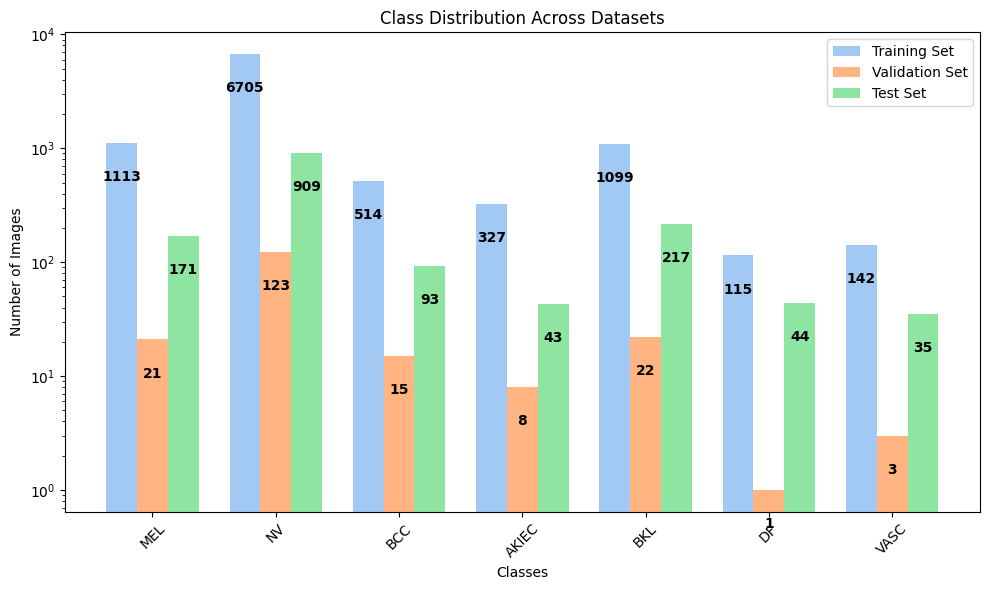

In [ ]:
# Count the occurrences of each class in the training, validation, and test sets
train_class_counts = train_df.iloc[:, 1:].sum(axis=0)  # Summing each class column in training data
val_class_counts = val_df.iloc[:, 1:].sum(axis=0)  # Summing each class column in validation data
test_class_counts = test_df.iloc[:, 1:].sum(axis=0)  # Summing each class column in test data

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Increased figure size

# Position for the bars of each dataset (training, validation, test)
x = range(len(classes))

# Width of bars
bar_width = 0.25

# Plotting the bars
train_bars = ax.bar([p - bar_width for p in x], train_class_counts.values, bar_width, label='Training Set', color=sns.color_palette("pastel", 7)[0])
val_bars = ax.bar(x, val_class_counts.values, bar_width, label='Validation Set', color=sns.color_palette("pastel", 7)[1])
test_bars = ax.bar([p + bar_width for p in x], test_class_counts.values, bar_width, label='Test Set', color=sns.color_palette("pastel", 7)[2])

# Adding numbers inside each bar
for bar in train_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(int(height)), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

for bar in val_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(int(height)), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

for bar in test_bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height / 2, str(int(height)), ha='center', va='center', color='black', fontsize=10, fontweight='bold')

# Adding labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution Across Datasets')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Set logarithmic scale on the y-axis
ax.set_yscale('log')

# Rotate x-axis labels to make them fit
plt.xticks(rotation=45)

# Save the plot with high quality
plt.tight_layout()
plt.savefig('class_distribution_high_quality.pdf', dpi=600)  # Save as PDF with high quality

# Display plot
plt.show()


Epoch [1/200], Train Loss: 0.7190, Train Accuracy: 0.7477
Epoch [1/200], Validation Loss: 0.4700, Validation Accuracy: 0.8187
Validation loss decreased (0.4700 -> 0.4700). Saving model...
Epoch [2/200], Train Loss: 0.4736, Train Accuracy: 0.8207
Epoch [2/200], Validation Loss: 0.4949, Validation Accuracy: 0.7927
Validation loss did not improve. Counter: 1/15
Epoch [3/200], Train Loss: 0.3068, Train Accuracy: 0.8899
Epoch [3/200], Validation Loss: 0.5378, Validation Accuracy: 0.7617
Validation loss did not improve. Counter: 2/15
Epoch [4/200], Train Loss: 0.2114, Train Accuracy: 0.9244
Epoch [4/200], Validation Loss: 1.2262, Validation Accuracy: 0.7150
Validation loss did not improve. Counter: 3/15
Epoch [5/200], Train Loss: 0.1525, Train Accuracy: 0.9441
Epoch [5/200], Validation Loss: 0.5574, Validation Accuracy: 0.7876
Validation loss did not improve. Counter: 4/15
Epoch [6/200], Train Loss: 0.1055, Train Accuracy: 0.9618
Epoch [6/200], Validation Loss: 0.7188, Validation Accuracy: 0

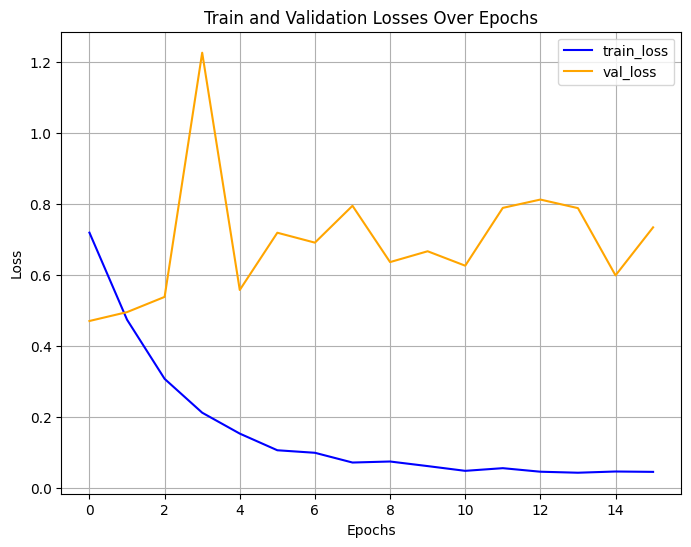

In [8]:
# Model setup (using a pre-trained ResNet50 model)
model = models.resnet50(weights='IMAGENET1K_V1')  # Corrected: using the 'weights' argument
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))  # Modify output layer for classification

# Move model to GPU if available
device = torch.device("cuda")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Early stopping instance
early_stopping = EarlyStopping(patience=15, verbose=True, path='best_model.pth')

# Lists to store train and validation losses
train_losses = []
val_losses = []

# Training Loop with Early Stopping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds
    train_losses.append(train_loss)  # Store train loss for plotting

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_preds / total_preds
    val_losses.append(val_loss)  # Store validation loss for plotting

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Check for early stopping
    if early_stopping(model, val_loss):
        print('Training stopped early')
        break

# Plotting the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='train_loss', color='blue')
plt.plot(val_losses, label='val_loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# After the training and validation loops, evaluate on the test set:
model.eval()  # Set the model to evaluation mode

# Initialize variables to track the test loss, accuracy and per-class metrics
test_loss = 0.0
correct_preds = 0
total_preds = 0
num_classes= 7

# Initialize a list to track the true positives and false positives for each class
class_correct = [0] * num_classes  # List to track correct predictions per class
class_total = [0] * num_classes  # List to track total samples per class

# Disable gradient computation as we do not need it for evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Assuming test_loader is defined
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

        # Update per-class metrics
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i].item() == label:
                class_correct[label] += 1

# Calculate average test loss and accuracy
average_test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

# Print out the overall test results
print(f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calculate and print accuracy for each class
for i in range(num_classes):
    class_accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"Accuracy for class {classes[i]}: {class_accuracy:.4f}")

Test Loss: 1.3629, Test Accuracy: 0.7169
Accuracy for class MEL: 0.4419
Accuracy for class NV: 0.4409
Accuracy for class BCC: 0.3917
Accuracy for class AKIEC: 0.2955
Accuracy for class BKL: 0.4327
Accuracy for class DF: 0.9230
Accuracy for class VASC: 0.3714


In [ ]:
# Define a simpler CNN model with Batch Normalization, Dropout, and L2 Regularization (weight decay)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):  # num_classes is 7 for ISIC 2018
        super(SimpleCNN, self).__init__()
        
        # Convolutional Layer 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # Batch Normalization after conv1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # MaxPooling layer
        
        # Convolutional Layer 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # Batch Normalization after conv2
        
        # Convolutional Layer 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)  # Batch Normalization after conv3
        
        # Fully Connected Layer (after flattening the output of convolutional layers)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 64 channels, 8x8 feature maps after pooling
        self.dropout = nn.Dropout(0.4)  # Dropout layer with 40% probability
        self.fc2 = nn.Linear(512, num_classes)  # Final output layer with the number of classes

    def forward(self, x):
        # Apply first convolutional layer with ReLU and batch normalization
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        
        # Apply second convolutional layer with ReLU and batch normalization
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        
        # Apply third convolutional layer with ReLU and batch normalization
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        
        # Flatten the output to feed into the fully connected layer
        x = x.view(-1, 64 * 8 * 8)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)  # Final output layer
        
        return x

# Initialize the model
model = SimpleCNN(num_classes=7)  # Adjust num_classes 
print(model)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Applying L2 regularization (weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler (decay the learning rate every 5 epochs by a factor of 0.5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Early stopping instance (make sure the EarlyStopping class is defined)
early_stopping = EarlyStopping(patience=15, verbose=True, path='best_model.pth')

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=512, out_features=7, bias=True)
)


Epoch 1/200, Train Loss: 0.9233, Train Accuracy: 0.6761
Validation Loss: 0.8915, Validation Accuracy: 0.7565
Validation loss decreased (6.2408 -> 6.2408). Saving model...
Epoch 2/200, Train Loss: 0.8123, Train Accuracy: 0.7059
Validation Loss: 0.7820, Validation Accuracy: 0.7254
Validation loss decreased (5.4739 -> 5.4739). Saving model...
Epoch 3/200, Train Loss: 0.7768, Train Accuracy: 0.7131
Validation Loss: 0.7745, Validation Accuracy: 0.7617
Validation loss decreased (5.4212 -> 5.4212). Saving model...
Epoch 4/200, Train Loss: 0.7600, Train Accuracy: 0.7169
Validation Loss: 0.9169, Validation Accuracy: 0.7772
Validation loss did not improve. Counter: 1/15
Epoch 5/200, Train Loss: 0.7501, Train Accuracy: 0.7273
Validation Loss: 0.6827, Validation Accuracy: 0.7876
Validation loss decreased (4.7791 -> 4.7791). Saving model...
Epoch 6/200, Train Loss: 0.7059, Train Accuracy: 0.7379
Validation Loss: 0.5592, Validation Accuracy: 0.8031
Validation loss decreased (3.9147 -> 3.9147). Savin

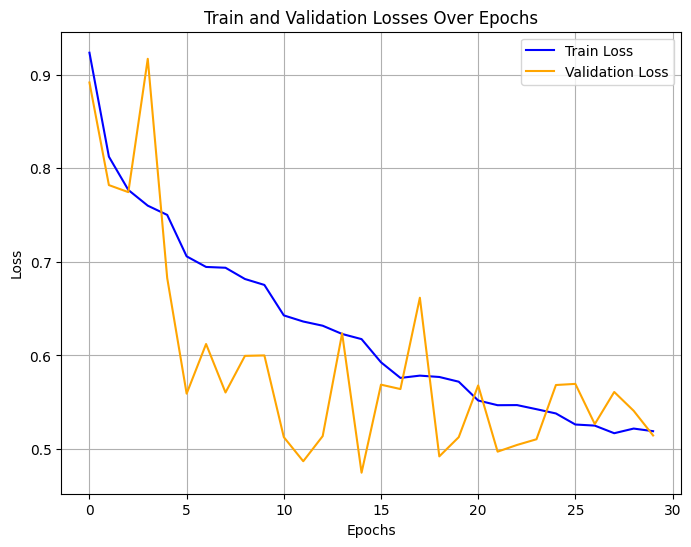

In [20]:
# Example Training Loop
num_epochs = 200
train_losses = []  # Initialize list for storing train losses
val_losses = []    # Initialize list for storing validation losses
device = torch.device("cuda")
model = model.to(device)  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:  # Assuming train_loader is defined
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds
    train_losses.append(epoch_loss)  # Save for plotting

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

    # Validation step
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for images, labels in val_loader:  # Assuming val_loader is defined
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

        val_accuracy = correct_preds / total_preds
        val_losses.append(val_loss / len(val_loader))  # Save for plotting
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Check for early stopping
        if early_stopping(model, val_loss):
            print('Training stopped early')
            break

    # Step the scheduler at the end of each epoch
    scheduler.step()

# Plotting the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# After the training and validation loops, evaluate on the test set:
model.eval()  # Set the model to evaluation mode

# Initialize variables to track the test loss, accuracy and per-class metrics
test_loss = 0.0
correct_preds = 0
total_preds = 0
num_classes= 7

# Initialize a list to track the true positives and false positives for each class
class_correct = [0] * num_classes  # List to track correct predictions per class
class_total = [0] * num_classes  # List to track total samples per class

# Disable gradient computation as we do not need it for evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Assuming test_loader is defined
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

        # Update per-class metrics
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i].item() == label:
                class_correct[label] += 1

# Calculate average test loss and accuracy
average_test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

# Print out the overall test results
print(f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calculate and print accuracy for each class
for i in range(num_classes):
    class_accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"Accuracy for class {classes[i]}: {class_accuracy:.4f}")



Test Loss: 0.8093, Test Accuracy: 0.7110
Accuracy for class MEL: 0.3256
Accuracy for class NV: 0.5161
Accuracy for class BCC: 0.4147
Accuracy for class AKIEC: 0.0000
Accuracy for class BKL: 0.4035
Accuracy for class DF: 0.9219
Accuracy for class VASC: 0.4571


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Ander/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s] 


ResNet18Model(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

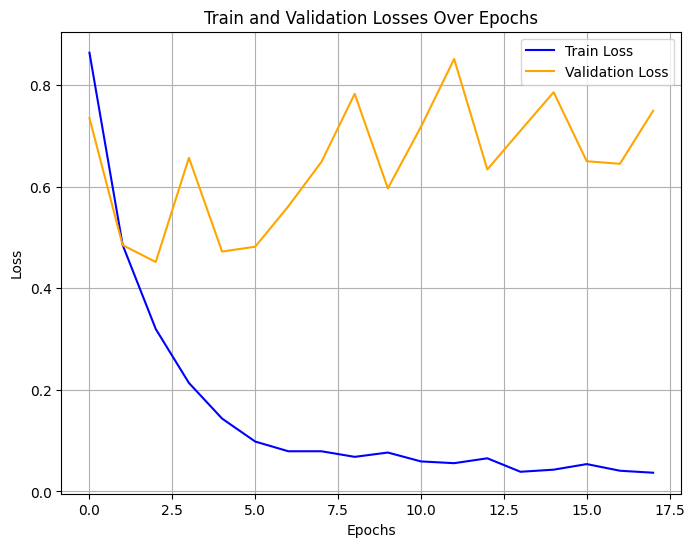

Test Loss: 1.5734, Test Accuracy: 0.7097
Accuracy for class MEL: 0.4186
Accuracy for class NV: 0.4409
Accuracy for class BCC: 0.3548
Accuracy for class AKIEC: 0.5000
Accuracy for class BKL: 0.5029
Accuracy for class DF: 0.8966
Accuracy for class VASC: 0.4000


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt

# Define the model using pre-trained ResNet18
class ResNet18Model(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet18Model, self).__init__()
        
        # Load pre-trained ResNet18
        self.resnet18 = models.resnet18(weights='IMAGENET1K_V1')  # Pre-trained weights
        
        # Replace the final fully connected layer to match the number of classes
        self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.resnet18(x)

# Initialize the model
model = ResNet18Model(num_classes=7)  # Adjust num_classes based on your dataset
print(model)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Early stopping instance (make sure the EarlyStopping class is defined)
early_stopping = EarlyStopping(patience=15, verbose=True, path='best_model.pth')

# Lists to store train and validation losses
train_losses = []
val_losses = []

# Training Loop with Early Stopping
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds
    train_losses.append(train_loss)  # Store train loss for plotting

    # Validation Loop
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct_preds / total_preds
    val_losses.append(val_loss)  # Store validation loss for plotting

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Check for early stopping
    if early_stopping(model, val_loss):
        print('Training stopped early')
        break

# Plotting the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# After the training and validation loops, evaluate on the test set:
model.eval()  # Set the model to evaluation mode

# Initialize variables to track the test loss, accuracy and per-class metrics
test_loss = 0.0
correct_preds = 0
total_preds = 0
num_classes = 7

# Initialize a list to track the true positives and false positives for each class
class_correct = [0] * num_classes  # List to track correct predictions per class
class_total = [0] * num_classes  # List to track total samples per class

# Disable gradient computation as we do not need it for evaluation
with torch.no_grad():
    for images, labels in test_loader:  # Assuming test_loader is defined
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        # Forward pass
        outputs = model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_preds += labels.size(0)
        correct_preds += (predicted == labels).sum().item()

        # Update per-class metrics
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i].item() == label:
                class_correct[label] += 1

# Calculate average test loss and accuracy
average_test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

# Print out the overall test results
print(f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Calculate and print accuracy for each class
for i in range(num_classes):
    class_accuracy = class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0
    print(f"Accuracy for class {classes[i]}: {class_accuracy:.4f}")
